In [93]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
import re
import string
import numpy as np
import pandas as pd
from pprint import pprint
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import spacy
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
%matplotlib inline
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)
import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

## Read data
We are using data from GDELT that has been cleaned and classified using BERT.

In [94]:
data = pd.read_csv('cleandata.txt', sep = '\t')
data.head()

,Unnamed: 0,Unnamed: 0.1,Date,NumArticles,Counts,Themes,Locations,Persons,Organizations,ToneData,CAMEOEvents,Sources,SourceURLs,text,class
0,0,0,20180301,1,NaN,WB_1921_PRIVATE_SECTOR_DEVELOPMENT;WB_405_BUSI...,"1#China#CH#CH#35#105#CH;4#Shanghai, Shanghai, ...",robin li;lihong qin,motor corp ltd;information technology;xinhua;s...,"0.873362445414847,2.18340611353712,1.310043668...",735029480,newsweek.com,http://www.newsweek.com/self-driving-cars-fina...,China issued licenses to auto makers on Thursd...,autonomous
1,1,1,20180301,1,NaN,TAX_FNCACT;TAX_FNCACT_STUDENT;TAX_FNCACT_STUDE...,1#United Kingdom#UK#UK#54#-4#UK,andrew deakin,cardiff university,"4.02476780185759,4.64396284829721,0.6191950464...",NaN,theengineer.co.uk,https://www.theengineer.co.uk/formula-student-...,Formula Student will celebrate its 20th annive...,autonomous
2,3,3,20180301,2,NaN,TAX_FNCACT;TAX_FNCACT_REGULATORS;PUBLIC_TRANSP...,"3#Washington, Washington, United States#US#USD...",donald trump;derek kan;barack obama;elaine chao,railroad administration;transit administration...,"0,1.34228187919463,1.34228187919463,2.68456375...","734827665,734827620,734827665,734827975,735120...",reuters.com;reuters.com,https://www.reuters.com/article/us-autos-selfd...,WASHINGTON (Reuters) - U.S. Transportation Sec...,autonomous
3,5,5,20180301,1,NaN,DRONES;TAX_FNCACT;TAX_FNCACT_DRIVERS;TAX_FNCAC...,"3#Phoenix, Arizona, United States#US#USAZ#33.4...",google waymo;jean shiomoto,california department of motor vehicles;chrysler,"-1.23456790123457,1.23456790123457,2.469135802...",NaN,thecarconnection.com,https://www.thecarconnection.com/news/1115539_...,Uber launches self-driving pilot in San Franci...,autonomous
4,7,7,20180301,1,NaN,TAX_FNCACT;TAX_FNCACT_PILOT;EPU_ECONOMY_HISTOR...,"3#Miami, Florida, United States#US#USFL#25.774...",john kwant;sam abuelsamid;sherif marakby;carlo...,google;nissan motor co;ford motor co;consumer ...,"0.572519083969466,2.19465648854962,1.622137404...",NaN,pressherald.com,https://www.pressherald.com/2018/02/28/ford-to...,The company is partnering with Domino's Pizza ...,autonomous


## Pre-Processing

To prepare the data for topic modeling, we will employ gensim's simple preprocessing method, which performs basic transformations like removing punctuation and casing. Then we will remove stopwords, create bigrams and trigrams of common terms, and lemmatize words. Finally, we will create a corpus.

In [95]:
#basic preprocessing

text = data['text'].tolist()

#tokenize by sentence
docs = [sent_tokenize(doc) for doc in text]

#preprocess each document
def preprocess(doc):
    for sentence in doc:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
docs = [list(preprocess(doc)) for doc in docs]

print(docs[0])

[['china', 'issued', 'licenses', 'to', 'auto', 'makers', 'on', 'thursday', 'that', 'allow', 'self', 'driving', 'vehicles', 'to', 'be', 'road', 'tested', 'for', 'the', 'first', 'time', 'the', 'state', 'owned', 'xinhua', 'news', 'agency', 'reported'], ['two', 'licenses', 'were', 'offered', 'to', 'shanghai', 'based', 'saic', 'motor', 'corp', 'ltd', 'and', 'the', 'other', 'went', 'to', 'electric', 'vehicle', 'start', 'up', 'nio', 'xinhua', 'reported'], ['nio', 'confirmed', 'it', 'received', 'license'], ['there', 'was', 'no', 'immediate', 'comment', 'from', 'saic'], ['the', 'licenses', 'would', 'allow', 'operators', 'to', 'test', 'drive', 'the', 'vehicles', 'on', 'km', 'mile', 'public', 'road', 'in', 'jiading', 'district', 'of', 'shanghai', 'xinhua', 'said'], ['the', 'licenses', 'were', 'issued', 'after', 'robin', 'li', 'the', 'boss', 'of', 'china', 'biggest', 'search', 'engine', 'baidu', 'tested', 'his', 'firm', 'driverless', 'car', 'on', 'beijing', 'roads', 'in', 'july', 'stirring', 'cont

In [96]:
# build bigram and trigram models

# flatten docs list
flat_docs = [item for sublist in docs for item in sublist]

bigram = gensim.models.Phrases(flat_docs, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[flat_docs], threshold=100)

bigram_mod = gensim.models.phrases.Phraser(bigram)
bigram_mod = gensim.models.phrases.Phraser(trigram)

In [97]:
# functions for additional preprocessing

# remove stopwords
stop_words = stopwords.words('english')
def remove_stopwords(docs):
    return [[[word for word in sentence if word not in stop_words] for sentence in doc] for doc in docs]

# form bigrams
def make_bigrams(docs):
    return [[bigram_mod[sentence] for sentence in doc] for doc in docs]

#form trigrams
def make_trigrams(docs):
    return [[trigram_mod[bigram_mod[sentence]] for sentence in doc] for doc in docs]

#lemmatize (requires flattened sentence lists)
def lemmatization(docs, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    doc_list = []
    for doc in docs:
        doc = nlp(" ".join(doc))
        doc_list.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return doc_list

In [98]:
# perform additional preprocessing

docs = remove_stopwords(docs)
docs = make_bigrams(docs)
docs = make_trigrams(docs)

# flatten sentence list within each doc
flattened_docs = [[item for sublist in doc for item in sublist] for doc in docs]

#lemmatization
nlp = spacy.load('en', disable=['parser','ner'])
docs_lemmatized = lemmatization(flattened_docs)

In [99]:
print(docs_lemmatized[0])

['issue', 'auto', 'maker', 'allow', 'self', 'driving', 'vehicle', 'road', 'test', 'first', 'time', 'state', 'own', 'report', 'license', 'offer', 'base', 'go', 'electric', 'vehicle', 'start', 'report', 'confirm', 'received', 'license', 'immediate', 'comment', 'saic', 'license', 'would', 'allow', 'operator', 'test', 'drive', 'vehicle', 'km', 'mile', 'public', 'say', 'license', 'issue', 'boss', 'big', 'baidu', 'test', 'firm', 'driverless', 'car', 'road', 'stir', 'controversy', 'rule', 'say', 'say', 'receive', 'municipal', 'government', 'drive', 'say', 'statement', 'read', 'driverless', 'taxis', 'mark', 'end', 'automotive', 'era', 'waymo', 'test', 'self', 'drive', 'car', 'human', 'also', 'issue', 'regulation', 'road', 'test', 'smart', 'car', 'say', 'would', 'promote', 'application', 'vehicle', 'use', 'artificial_intelligence', 'technology', 'internet', 'link', 'function', 'report', 'road', 'test', 'smart', 'say', 'accord', 'weekly', 'magazine', 'deliver', 'website', 'access', 'weekly', 'ma

In [101]:
# create dictionary
id2word = corpora.Dictionary(docs_lemmatized)

# create corpus
corpus = [id2word.doc2bow(doc) for doc in docs_lemmatized]

In [103]:
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('access', 4), ('accord', 1), ('allow', 2), ('also', 1), ('application', 1), ('artificial_intelligence', 1), ('auto', 1), ('automotive', 1), ('baidu', 1), ('base', 1), ('big', 1), ('boss', 1), ('car', 3), ('comment', 1), ('confirm', 1), ('controversy', 1), ('deliver', 2), ('digital', 1), ('drive', 3), ('driverless', 2), ('driving', 1), ('edition', 1), ('electric', 1), ('end', 1), ('era', 1), ('firm', 1), ('first', 1), ('free', 1), ('function', 1), ('go', 1), ('government', 1), ('human', 1), ('immediate', 1), ('internet', 1), ('issue', 3), ('km', 1), ('license', 4), ('link', 1), ('magazine', 2), ('maker', 1), ('mark', 1), ('mile', 1), ('municipal', 1), ('offer', 1), ('operator', 1), ('own', 1), ('promote', 1), ('public', 1), ('read', 1), ('receive', 1), ('received', 1), ('regulation', 1), ('report', 3), ('road', 4), ('rule', 1), ('saic', 1), ('say', 6), ('self', 2), ('smart', 2), ('start', 1), ('state', 1), ('statement', 1), ('stir', 1), ('taxis', 1), ('technology', 1), ('test', 6), (

## Topic Modeling

We will use LDA for topic modeling and test several models with different numbers of topics.

In [110]:
# Test LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=5, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.057*"say" + 0.035*"crash" + 0.033*"vehicle" + 0.023*"state" + '
  '0.016*"test" + 0.015*"autonomous" + 0.014*"company" + 0.013*"technology" + '
  '0.013*"regulation" + 0.011*"first"'),
 (1,
  '0.039*"driver" + 0.032*"system" + 0.028*"say" + 0.026*"video" + '
  '0.019*"year" + 0.017*"camera" + 0.015*"radar" + 0.013*"show" + 0.012*"see" '
  '+ 0.012*"laser"'),
 (2,
  '0.012*"use" + 0.008*"vehicle" + 0.007*"company" + 0.007*"year" + '
  '0.006*"time" + 0.006*"new" + 0.006*"may" + 0.006*"provide" + '
  '0.006*"service" + 0.006*"term"'),
 (3,
  '0.032*"car" + 0.021*"drive" + 0.020*"self" + 0.018*"vehicle" + '
  '0.012*"technology" + 0.011*"autonomous" + 0.010*"say" + 0.009*"company" + '
  '0.009*"driving" + 0.008*"driver"'),
 (4,
  '0.044*"vehicle" + 0.040*"self" + 0.031*"say" + 0.031*"car" + 0.026*"drive" '
  '+ 0.024*"crash" + 0.022*"test" + 0.020*"autonomous" + 0.018*"driving" + '
  '0.018*"company"')]


In [126]:
# test with different numbers of topics
ks = []
perplexity = []
coherence_score = []

for k in range(2,21):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=k, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    #print("k: ", k)
    ks.append(k)
    p = lda_model.log_perplexity(corpus)
    #print("perplexity: ", p)
    perplexity.append(p)
    coherence_model_lda = CoherenceModel(model=lda_model, texts=docs_lemmatized, dictionary=id2word, coherence='c_v')
    coherence = coherence_model_lda.get_coherence()
    coherence_score.append(coherence)
    #print('coherence: ', coherence)
    #print('')

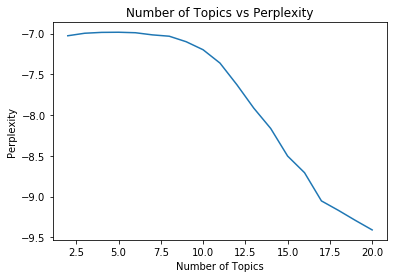

In [127]:
# plot number of topics vs perplexity
plt.plot(ks, perplexity)
plt.xlabel('Number of Topics')
plt.ylabel('Perplexity')
plt.title('Number of Topics vs Perplexity')
plt.show()

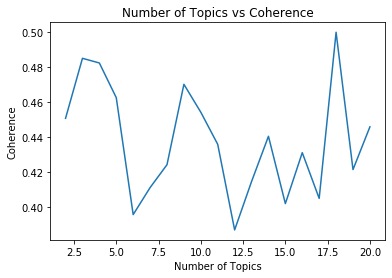

In [128]:
# plot k vs coherence
plt.plot(ks, coherence_score)
plt.xlabel('Number of Topics')
plt.ylabel('Coherence')
plt.title('Number of Topics vs Coherence')
plt.show()

Higher perplexity and coherence scores are best. Given these results, we will investigate three models: 3 topics, 4 topics, and 18 topics. Both the 3 topic and 4 topic models have high perplexity and coherence scores compared to others. The 18 topic model has low perplexity, but the highest coherence score of an any model, so it is worth investigating.

### First Model: 3 Topics

In [133]:
# fit 3 topic LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=3, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.040*"vehicle" + 0.034*"say" + 0.032*"self" + 0.027*"car" + 0.021*"crash" '
  '+ 0.021*"drive" + 0.019*"test" + 0.018*"autonomous" + 0.016*"company" + '
  '0.015*"driving"'),
 (1,
  '0.037*"driver" + 0.027*"video" + 0.025*"system" + 0.024*"say" + '
  '0.016*"year" + 0.014*"camera" + 0.013*"show" + 0.012*"see" + 0.012*"radar" '
  '+ 0.011*"look"'),
 (2,
  '0.025*"car" + 0.016*"drive" + 0.014*"self" + 0.014*"vehicle" + '
  '0.009*"technology" + 0.008*"autonomous" + 0.008*"company" + 0.007*"say" + '
  '0.006*"make" + 0.006*"use"')]


In [134]:
# visualize topics

pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2     -0.112006  0.130947       1        1  53.060734
0     -0.130029 -0.124604       2        1  39.666077
1      0.242035 -0.006343       3        1   7.273190, topic_info=     Category          Freq         Term         Total  loglift  logprob
216   Default   5843.000000       driver   5843.000000  30.0000  30.0000
56    Default  10559.000000          say  10559.000000  29.0000  29.0000
172   Default   3299.000000       system   3299.000000  28.0000  28.0000
675   Default   2398.000000        video   2398.000000  27.0000  27.0000
760   Default   5129.000000        crash   5129.000000  26.0000  26.0000
182   Default   3446.000000         year   3446.000000  25.0000  25.0000
68    Default  13030.000000      vehicle  13030.000000  24.0000  24.0000
479   Default   1846.000000         show   1846.000000  23.0000  23.0000
163   Default   1907.000000          see   1907.000000  22.0000  22.0000
65    Default   5627.000000         test   5627.000000  21.0000  21.0000
137   Default   1507.000000         look   1507.000000  20.0000  20.0000
57    Default  11411.000000         self  11411.000000  19.0000  19.0000
1245  Default    864.000000       camera    864.000000  18.0000  18.0000
499   Default   2910.000000      testing   2910.000000  17.0000  17.0000
60    Default   2749.000000        state   2749.000000  16.0000  16.0000
1011  Default   1419.000000       sensor   1419.000000  15.0000  15.0000
1477  Default   2107.000000       police   2107.000000  14.0000  14.0000
256   Default   1414.000000     question   1414.000000  13.0000  13.0000
677   Default   1017.000000         well   1017.000000  12.0000  12.0000
1173  Default   3249.000000   pedestrian   3249.000000  11.0000  11.0000
1391  Default   3514.000000     accident   3514.000000  10.0000  10.0000
1291  Default    627.000000        radar    627.000000   9.0000   9.0000
7527  Default   1579.000000      suspend   1579.000000   8.0000   8.0000
31    Default   3157.000000        human   3157.000000   7.0000   7.0000
1007  Default    906.000000       second    906.000000   6.0000   6.0000
79    Default   6444.000000   autonomous   6444.000000   5.0000   5.0000
288   Default    606.000000         view    606.000000   4.0000   4.0000
1671  Default   2567.000000         kill   2567.000000   3.0000   3.0000
419   Default    662.000000        light    662.000000   2.0000   2.0000
663   Default    976.000000         tell    976.000000   1.0000   1.0000
...       ...           ...          ...           ...      ...      ...
288    Topic3    376.123291         view    606.598145   2.1430  -4.6888
675    Topic3   1085.721313        video   2398.186523   1.8285  -3.6287
3167   Topic3    146.437561       screen    193.319122   2.3432  -5.6321
172    Topic3   1029.214966       system   3299.494141   1.4560  -3.6822
216    Topic3   1518.475830       driver   5843.295898   1.2734  -3.2932
712    Topic3    149.984268         pick    221.869904   2.2294  -5.6082
634    Topic3    204.830826       moment    355.285217   2.0702  -5.2965
419    Topic3    307.478699        light    662.461792   1.8534  -4.8903
2364   Topic3    215.350876      prevent    385.305237   2.0392  -5.2464
780    Topic3    164.651596     identify    258.730377   2.1690  -5.5149
553    Topic3    207.948303        range    379.638153   2.0190  -5.2814
479    Topic3    538.345459         show   1846.951660   1.3882  -4.3302
349    Topic3    246.708633        brake    542.771484   1.8325  -5.1105
137    Topic3    454.867065         look   1507.503784   1.4228  -4.4987
440    Topic3    144.129135          one    222.506378   2.1867  -5.6480
163    Topic3    491.881989          see   1907.427368   1.2657  -4.4205
1007   Topic3    316.396973       second    906.451294   1.5684  -4.8617
182    Topic3    647.744507         year   3446.192871   0.9494  -4.1452
1011   Topic3    374.625641       sen

#### Results:
These topics can be can be roughly categorized as 1) General (it is not clear exactly what this topic encompasses aside from autonomous cars as a whole), 2) Accidents and safety, and 3) Technology (in particular, the sensor system with words like "camera," "radar," and "laser."

### Second Model: 4 Topics

In [135]:
# fit 4 topic LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.044*"vehicle" + 0.037*"say" + 0.034*"crash" + 0.025*"self" + 0.025*"car" '
  '+ 0.021*"drive" + 0.019*"pedestrian" + 0.018*"driver" + 0.017*"autonomous" '
  '+ 0.014*"test"'),
 (1,
  '0.035*"driver" + 0.032*"video" + 0.025*"say" + 0.025*"system" + '
  '0.018*"year" + 0.014*"camera" + 0.013*"see" + 0.013*"show" + 0.013*"look" + '
  '0.013*"radar"'),
 (2,
  '0.023*"car" + 0.012*"drive" + 0.011*"vehicle" + 0.007*"self" + '
  '0.006*"technology" + 0.006*"system" + 0.006*"make" + 0.006*"autonomous" + '
  '0.006*"use" + 0.006*"may"'),
 (3,
  '0.044*"self" + 0.030*"car" + 0.029*"vehicle" + 0.026*"drive" + 0.026*"say" '
  '+ 0.024*"test" + 0.022*"company" + 0.019*"driving" + 0.018*"autonomous" + '
  '0.014*"technology"')]


In [124]:
# visualize topics

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.042596  0.184959       1        1  43.427677
3      0.147758 -0.000581       2        1  26.115946
0      0.101319 -0.156671       3        1  24.518003
1     -0.291673 -0.027706       4        1   5.938370, topic_info=     Category          Freq           Term         Total  loglift  logprob
216   Default   5972.000000         driver   5972.000000  30.0000  30.0000
56    Default  10734.000000            say  10734.000000  29.0000  29.0000
760   Default   5326.000000          crash   5326.000000  28.0000  28.0000
675   Default   2428.000000          video   2428.000000  27.0000  27.0000
57    Default  11558.000000           self  11558.000000  26.0000  26.0000
172   Default   3322.000000         system   3322.000000  25.0000  25.0000
68    Default  13188.000000        vehicle  13188.000000  24.0000  24.0000
65    Default   5657.000000           test   5657.000000  23.0000  23.0000
182   Default   3480.000000           year   3480.000000  22.0000  22.0000
1173  Default   3350.000000     pedestrian   3350.000000  21.0000  21.0000
163   Default   1887.000000            see   1887.000000  20.0000  20.0000
20    Default   5211.000000        driving   5211.000000  19.0000  19.0000
203   Default   6118.000000        company   6118.000000  18.0000  18.0000
479   Default   1882.000000           show   1882.000000  17.0000  17.0000
1477  Default   2186.000000         police   2186.000000  16.0000  16.0000
137   Default   1502.000000           look   1502.000000  15.0000  15.0000
18    Default   9605.000000          drive   9605.000000  14.0000  14.0000
499   Default   2893.000000        testing   2893.000000  13.0000  13.0000
1245  Default    855.000000         camera    855.000000  12.0000  12.0000
79    Default   6506.000000     autonomous   6506.000000  11.0000  11.0000
1671  Default   2633.000000           kill   2633.000000  10.0000  10.0000
47    Default   2674.000000         public   2674.000000   9.0000   9.0000
1391  Default   3536.000000       accident   3536.000000   8.0000   8.0000
60    Default   2738.000000          state   2738.000000   7.0000   7.0000
12    Default  13499.000000            car  13499.000000   6.0000   6.0000
69    Default   1162.000000          waymo   1162.000000   5.0000   5.0000
1011  Default   1419.000000         sensor   1419.000000   4.0000   4.0000
1291  Default    636.000000          radar    636.000000   3.0000   3.0000
677   Default   1023.000000           well   1023.000000   2.0000   2.0000
2339  Default   1022.000000  investigation   1022.000000   1.0000   1.0000
...       ...           ...            ...           ...      ...      ...
3585   Topic4     89.320679     absolutely    103.583344   2.6756  -5.9237
172    Topic4    832.844482         system   3322.105469   1.4402  -3.6911
216    Topic4   1177.848145         driver   5972.439941   1.2003  -3.3445
1422   Topic4    223.162460           dark    441.247864   2.1420  -5.0080
712    Topic4    145.838226           pick    232.987122   2.3553  -5.4334
137    Topic4    425.894073           look   1502.146362   1.5633  -4.3618
771    Topic4    289.593719         expert    773.556763   1.8412  -4.7475
419    Topic4    265.177032          light    667.485352   1.9006  -4.8355
534    Topic4    255.382935          email    629.695984   1.9213  -4.8732
553    Topic4    185.818405          range    377.745972   2.1143  -5.1912
163    Topic4    450.126251            see   1887.023071   1.3905  -4.3064
634    Topic4    177.755020         moment    357.091858   2.1261  -5.2355
182    Topic4    597.124939           year   3480.371094   1.0610  -4.0238
479    Topic4    426.793152           show   1882.876953   1.3395  -4.3596
2364   Topic4    180.905380        prevent    387.763397   2.0613  -5.2180
1007   Topic4    268.889801         second    913.538940   1.6007  -4.8216
1200   Topic4    169.063141      

#### Results:
These topics can be roughly categorized as 1) General (as in the first model, this topic is not well-defined), 2) Safety regulations and testing, 3) Accidents, and 4) Sensor system and technology. This appears to be an improvement on the first model as it is able to separate articles related to safety regulations and testing from articles related to specific accidents.

### Third Model: 18 Topics

In [131]:
# fit 18 topic LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=18, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.022*"use" + 0.012*"new" + 0.011*"model" + 0.010*"vehicle" + '
  '0.008*"electric" + 0.007*"share" + 0.007*"design" + 0.007*"autonomous" + '
  '0.007*"future" + 0.007*"world"'),
 (1,
  '0.069*"system" + 0.062*"driver" + 0.030*"sensor" + 0.028*"human" + '
  '0.024*"video" + 0.021*"camera" + 0.021*"see" + 0.021*"question" + '
  '0.020*"look" + 0.018*"show"'),
 (2,
  '0.042*"term" + 0.041*"provide" + 0.040*"site" + 0.035*"may" + 0.035*"news" '
  '+ 0.034*"datum" + 0.031*"com" + 0.031*"website" + 0.028*"information" + '
  '0.021*"condition"'),
 (3,
  '0.047*"self" + 0.027*"drive" + 0.025*"vehicle" + 0.024*"company" + '
  '0.023*"car" + 0.021*"driving" + 0.020*"technology" + 0.019*"autonomous" + '
  '0.018*"test" + 0.017*"safety"'),
 (4,
  '0.116*"car" + 0.075*"self" + 0.067*"vehicle" + 0.065*"drive" + '
  '0.038*"pedestrian" + 0.038*"autonomous" + 0.027*"test" + 0.026*"strike" + '
  '0.026*"driving" + 0.026*"driver"'),
 (5,
  '0.101*"patent" + 0.056*"motion" + 0.030*"plaintiff" + 

In [132]:
# visualize topics

vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

C:\ProgramData\Anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.266467 -0.005220       1        1  27.006165
13     0.194567  0.123745       2        1  18.953266
4      0.285858 -0.147592       3        1  11.296496
10     0.292281 -0.153797       4        1  10.458168
0      0.118169  0.237055       5        1   8.700461
7      0.283677 -0.134204       6        1   7.311725
1      0.200325  0.007378       7        1   5.968178
8      0.218602  0.008300       8        1   5.239911
16     0.038194  0.130278       9        1   2.293932
2     -0.021750  0.256871      10        1   1.283555
12    -0.120169 -0.065200      11        1   0.752877
15    -0.209523 -0.067199      12        1   0.462370
11    -0.239877  0.007466      13        1   0.112773
17    -0.259926 -0.053140      14        1   0.099021
5     -0.262810 -0.044369      15        1   0.036749
14    -0.262137 -0.036171      16        1   0.020193
9     -0.260974 -0.032100      17        1   0.002086
6     -0.260974 -0.032100      18        1   0.002068, topic_info=     Category          Freq                Term         Total  loglift  \
56    Default  12381.000000                 say  12381.000000  30.0000   
12    Default  16043.000000                 car  16043.000000  29.0000   
57    Default  12883.000000                self  12883.000000  28.0000   
68    Default  15373.000000             vehicle  15373.000000  27.0000   
760   Default   5994.000000               crash   5994.000000  26.0000   
216   Default   6267.000000              driver   6267.000000  25.0000   
18    Default  10994.000000               drive  10994.000000  24.0000   
172   Default   3295.000000              system   3295.000000  23.0000   
203   Default   6922.000000             company   6922.000000  22.0000   
2339  Default    908.000000       investigation    908.000000  21.0000   
60    Default   3201.000000               state   3201.000000  20.0000   
65    Default   6429.000000                test   6429.000000  19.0000   
1173  Default   3880.000000          pedestrian   3880.000000  18.0000   
428   Default   2414.000000                 may   2414.000000  17.0000   
64    Default   4961.000000          technology   4961.000000  16.0000   
1477  Default   2280.000000              police   2280.000000  15.0000   
675   Default   2476.000000               video   2476.000000  14.0000   
182   Default   4240.000000                year   4240.000000  13.0000   
67    Default   3302.000000                 use   3302.000000  12.0000   
1391  Default   3627.000000            accident   3627.000000  11.0000   
79    Default   7577.000000          autonomous   7577.000000  10.0000   
31    Default   3485.000000               human   3485.000000   9.0000   
52    Default   2429.000000              report   2429.000000   8.0000   
399   Default   1912.000000                 get   1912.000000   7.0000   
1835  Default   2070.000000              strike   2070.000000   6.0000   
66    Default   3114.000000                time   3114.000000   5.0000   
20    Default   5732.000000             driving   5732.000000   4.0000   
1968  Default   1242.000000               ducey   1242.000000   3.0000   
211   Default   1052.000000               datum   1052.000000   2.0000   
142   Default   2483.000000                 new   2483.000000   1.0000   
...       ...           ...                 ...           ...      ...   
6297  Topic18      0.000885           telescope      0.838427   3.9332   
4372  Topic18      0.000885          phenomenal      0.838427   3.9332   
4382  Topic18      0.000885            takeover      0.838432   3.9332   
4381  Topic18      0.000885             injured      0.838427   3.9332   
4380  Topic18      0.000885            damaging      0.838433   3.9332   
4379  Topic18      0.000885               bruin      0.838435   3.9332   
4378  Topic18      0.000885             thermal      0.838428   3

#### Results:
Overall, these topics are not well-defined. It does seem to pick out topics that other models do not - for example, topic 10 is potentially related to legal terms and topic 12 is related to aviation, but other topics are less clear and there's a good amount of overlap. Overall, it seems like we are sacrificing clarity on larger topics for clarity on a few small topics, which is not a good tradeoff.